In [1]:
%pylab inline
%matplotlib inline

import sys
import os
import time
import codecs
import pandas as pd
from pprint import pprint
import re

sys.path.append("/Users/Bya/git/predictEPL/utils/")
sys.path.append("/Users/Bya/git/predictEPL/config/")

import emolex
import paths
import tokenizer
import useful_methods as my_methods
import train_datas

Populating the interactive namespace from numpy and matplotlib


### Problem: Spam Filter

In [18]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc

In [30]:
###############################################

# 1. Data Load
os.chdir("/Users/Bya/Dropbox/Research/resources/smsspamcollection/")
df = pd.read_csv("SMSSpamCollection.txt", delimiter='\t', header=None)

dic_spam = {
    'ham': 0,
    'spam': 1
}
df[0] = [dic_spam[label] for label in df[0]]

print("Spam: ", df[df[0] == 1][0].count())
print("Ham: ", df[df[0] == 0][0].count())
df.head()

Spam:  747
Ham:  4825


,0,1
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
###############################################

# 2. Split data to
# Train(0.75), Test(0.25)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df[1], df[0], test_size = 0.25)

# 3. Data to Vector
# bag-of-words, tf-idf
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

# 4. Logistic Regression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

# Prediction Examples
for i, prediction in enumerate(predictions[:5]):
    print('Prediction: %s. \nMessage: %s\n\n' % (prediction, list(X_test_raw)[i]))

Prediction: 0. 
Message: Wherre's my boytoy ? :-(


Prediction: 0. 
Message: Sorry, I'll call later


Prediction: 0. 
Message: Me too baby! I promise to treat you well! I bet you will take good care of me...


Prediction: 1. 
Message: Urgent UR awarded a complimentary trip to EuroDisinc Trav, Aco&Entry41 Or £1000. To claim txt DIS to 87121 18+6*£1.50(moreFrmMob. ShrAcomOrSglSuplt)10, LS1 3AJ


Prediction: 0. 
Message: Aldrine, rakhesh ex RTM here.pls call.urgent.




## Binary classication performance metrics

### 1. Confusion Matrix

[[1195    2]
 [  39  157]]


/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


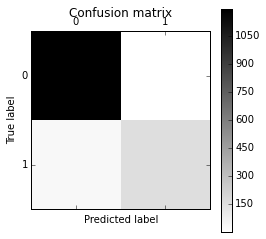

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

confusion_matrix = confusion_matrix(y_test, predictions)
print(confusion_matrix)

plt.matshow(confusion_matrix, cmap=plt.cm.binary, interpolation='nearest')
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### 2. Accuracy

In [9]:
from sklearn.metrics import accuracy_score

print('Accuracy:', accuracy_score(y_test, predictions))

Accuracy: 0.970567121321


In [10]:
###################
# Spam, Logistic Regression
# Accuracy

scores = cross_val_score(classifier, X_train, y_train, cv=5)
print(np.mean(scores), scores)

0.954293587714 [ 0.95459976  0.95813397  0.9569378   0.94730539  0.95449102]


### 3. Precision & Recall

In [12]:
# P = TP / (TP + FP)
precisions = cross_val_score(classifier, X_train, y_train,
                             cv=5, scoring='precision')

print('Precision: ', np.mean(precisions), precisions)

# R = TP / (TP + FN)
recalls = cross_val_score(classifier, X_train, y_train,
                          cv=5, scoring='recall')
print('Recalls: ', np.mean(recalls), recalls)

Precision:  0.986493506494 [ 0.97402597  0.98701299  1.          0.97142857  1.        ]
Recalls:  0.662407862408 [ 0.67567568  0.69090909  0.67272727  0.61818182  0.65454545]


### 4. Calculating the F1 measure

In [16]:
# F1 = 2 * PR / (P + R)

f1s = cross_val_score(classifier, X_train, y_train,
                      cv=5, scoring='f1')
print("F1: ", np.mean(f1s), f1s)

F1:  0.792363747575 [ 0.79787234  0.81283422  0.80434783  0.75555556  0.79120879]


### 5. ROC AUC 

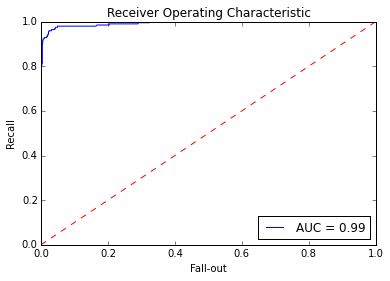

In [21]:
# Receiver Operating Characteristic = ROC curve
# Visualizes a classifier's performance
# for all values of the discrimination threshold. 

# fall out: F = FP / (TN + FP)

# AUC (area under the curve)

predictions_test = classifier.predict_proba(X_test)

false_positive_rate, recall, thresholds = roc_curve(
    y_test, predictions_test[:, 1])

roc_auc = auc(false_positive_rate, recall)

# Plot
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()

## Tunning Models with Grid Search

In [34]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [35]:
pipeline = Pipeline([
   ('vect', TfidfVectorizer(stop_words='english')),
   ('clf', LogisticRegression())
])
parameters = {
   'vect__max_df': (0.25, 0.5, 0.75),
   'vect__stop_words': ('english', None),
   'vect__max_features': (2500, 5000, 10000, None),
   'vect__ngram_range': ((1, 1), (1, 2)),
   'vect__use_idf': (True, False),
   'vect__norm': ('l1', 'l2'),
   'clf__penalty': ('l1', 'l2'),
   'clf__C': (0.01, 0.1, 1, 10),
}

In [36]:
grid_search = GridSearchCV(
    pipeline,
    parameters,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy',
    cv=3)

X, y, = df[1], df[0]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [37]:
grid_search.fit(X_train, y_train)

print('Best score: %0.3f' % grid_search.best_score_)
print('Best parameters set:')
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
   print('\t%s: %r' % (param_name, best_parameters[param_name]))
predictions = grid_search.predict(X_test)
print('Accuracy:', accuracy_score(y_test, predictions))
print('Precision:', precision_score(y_test, predictions))
print('Recall:', recall_score(y_test, predictions))

Fitting 3 folds for each of 1536 candidates, totalling 4608 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 200 jobs       | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 450 jobs       | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 800 jobs       | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1250 jobs       | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1800 jobs       | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 2450 jobs       | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 3200 jobs       | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 4050 jobs       | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 4602 out of 4608 | elapsed: 10.7min remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 4608 out of 4608 | elapsed: 10.7min finished


Best score: 0.984
Best parameters set:
	clf__C: 10
	clf__penalty: 'l2'
	vect__max_df: 0.25
	vect__max_features: 5000
	vect__ngram_range: (1, 2)
	vect__norm: 'l2'
	vect__stop_words: None
	vect__use_idf: True
Accuracy: 0.986360373295
Precision: 1.0
Recall: 0.90306122449
